In [ ]:
!pip install pycbc lalsuite ligo-common

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 51.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 MB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.2/201.2 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 83.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 76.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirem

In [ ]:
from pycbc import waveform
import matplotlib.pyplot as plt
import numpy as np
import lalsimulation as lalsim 
import lal 
import pylab
from pycbc.waveform.utils import frequency_from_polarizations
from pycbc.waveform.utils import phase_from_polarizations
from pycbc.types.timeseries import TimeSeries
from pycbc.filter.matchedfilter import match
import array

Modeling a tidally disrupted dark matter halo: Start an inspiral with an extra halo mass on the neutron star

In [ ]:
#GW190425 mass parameters 
m_NS = 1.3 # mass of neutron star in solar mass
m_BH = 2.1 # mass of black hole in solar mass

#GW200115 mass parameters 
m_NS2 = 1.44 # mass of neutron star in solar mass
m_BH2 = 5.9 # mass of black hole in solar mass

G = 6.6743*10**(-11) #in SI units
m_sun = 1.9891*10**30 #in kilograms or one solar mass

In [ ]:
# Generate a full inspiral with the  halo mass  stuck on the NS

misV = []
rlist = np.linspace(30, 300, 10)
slist = np.linspace(1, 10, 10)
R, S = np.meshgrid(rlist, slist)
for r in rlist:
    for s in slist:
       radsDM = r*10**3 #in KM
       massDM = 10**(-s)  #in solar masses  
       M_NS = m_sun*(m_NS + massDM) 
       M_BH = m_BH*m_sun
       r_T = radsDM*((M_BH/M_NS)**(1/3)) #tidal radius dark matter 
       a = r_T #orbital distance is the tidal disruption radius here
       period = ((4*(np.pi**2)*(a**3))/(G*(M_BH + M_NS)))**(1/2) #Kepler's thrid law with newtonian correction 
       frequency = 1/period

       hp, hc = waveform.get_td_waveform(
       approximant='SEOBNRv4',
       mass1=m_BH,
       mass2=m_NS+massDM, 
       distance=290, 
       f_ref=0, 
       delta_t=1.0/(16384),
        f_lower=20,
      )

       amplitude = np.sqrt(hp*hp+hc*hc)
       freq = frequency_from_polarizations(hp,hc)
       swapfreq = 2*frequency
       swaparg = np.argmin(abs(freq -swapfreq)) # closest sample to desired frequency
       swaptime = hp.sample_times[swaparg]
       swapfreq_exact = freq[swaparg]
       origphase = np.arctan2(hp.data[swaparg], hc.data[swaparg]) #phase at swap

# Generate a full inspiral with the new mass pair (BH)
       hp2, hc2 = waveform.get_td_waveform(
       approximant='SEOBNRv4',
       mass1=m_BH+massDM,
       mass2=m_NS, 
       distance=290, 
       delta_t=1.0/(16384),
       f_lower=swapfreq_exact,
       )

       freq2 = frequency_from_polarizations(hp2,hc2)
       swaparg2 = np.argmin(abs(freq2 - swapfreq)) # closest sample to desired frequency
       swaptime2 = hp2.sample_times[swaparg2]
       swapfreq_exact2 = freq[swaparg2]
       newphase = np.arctan2(hp2.data[swaparg2], hc2.data[swaparg2]) #phase at swap
#swaptime - swaptime2

       hpalign = (hp2.to_frequencyseries() * np.exp( -(origphase-newphase)*1.0j )).to_timeseries()
       hcalign = (hc2.to_frequencyseries() * np.exp( -(origphase-newphase)*1.0j )).to_timeseries()

       hpjoined = TimeSeries( np.concatenate([hp.data[:swaparg],hpalign.data[swaparg2+1:]]),delta_t=1.0/(16384)) 
       hcjoined = TimeSeries( np.concatenate([hc.data[:swaparg],hcalign.data[swaparg2+1:]]),delta_t=1.0/(16384)) 

# Resize the waveforms to the same length
       tlen = max(len(hp), len(hpjoined))
       hp.resize(tlen)
       hpjoined.resize(tlen)
      
       m,i = match(hp, hpjoined)
       mismatch = 1-m 
       misV.append(mismatch)  

In [ ]:
#creating a function which calls on particular mismatch values with respect to mass and radii parameters
def misval(r,s):
    return misV[int(r/rlist[0])+int(s/slist[0])-2]

#checking parameter outputs with respect to parameter inputs
print(rlist[0])
print(slist[0])
print(misval(rlist[0],slist[0]))

30.0
1.0
0.0007918863349831717


In [ ]:
#checking parameter inputs
rlist = np.linspace(30, 300, 10)
slist = np.linspace(1, 10, 10)
print(rlist)
print(slist)
print(rlist[0])
print(slist[0])

[ 30.  60.  90. 120. 150. 180. 210. 240. 270. 300.]
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
30.0
1.0


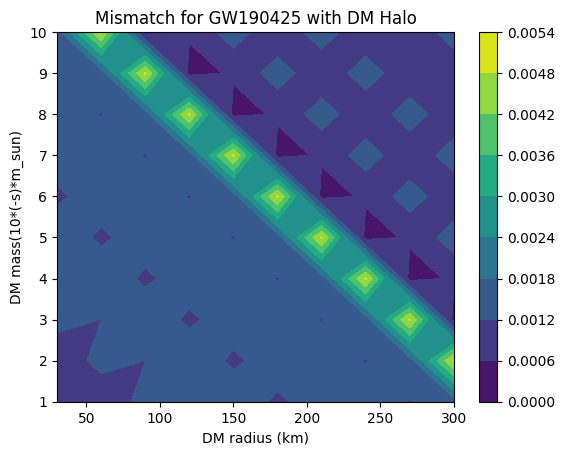

In [ ]:
misval2 = np.vectorize(misval)
R, S = np.meshgrid(rlist, slist)
M = misval2(R,S)
fig,ax=plt.subplots(1,1)
cp = ax.contourf(R, S, M)
fig.colorbar(cp)
ax.set_title('Mismatch for GW190425 with DM Halo')
ax.set_xlabel('DM radius (km)')
ax.set_ylabel('DM mass(10*(-s)*m_sun)')
plt.show()

Join the two models together: this is the signature of a halo disruption